In [76]:
import os
os.environ["DEVELOPMENT"] = "DEVELOPMENT"

In [77]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

from evolution.candidate import Candidate
from evolution.evaluation.evaluator import Evaluator

In [78]:
results_dir = Path("results/simplify/nofield")
config = json.load(open(results_dir / "config.json"))
# Number of numbered csv files
gens = len(list(results_dir.glob("[0-9]*.csv")))-1
tasks = config["evaluation_params"]["tasks"]
evaluation_params = config["evaluation_params"]
model_params = config["model_params"]
n_elites = config["evolution_params"]["n_elites"]
print(gens, tasks)

17 ['yield', 'irr']


In [79]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
candidates = []
print(final_pareto.sort_values(by="yield", ascending=False))

   cand_id             parents  rank  distance      yield     irr
0     12_1  ['11_78', '11_14']     1       inf  14.322066 -497.25
18   17_42  ['16_37', '16_28']     1  0.011289  14.172896 -483.00
8    16_77   ['14_2', '15_38']     1  0.037379  14.130718 -443.25
19   16_66  ['15_28', '15_47']     1  0.010586  14.117455 -424.50
16   17_76  ['16_68', '16_10']     1  0.016694  14.075095 -381.00
20   17_25  ['16_15', '15_63']     1  0.005881  14.020166 -377.25
13   17_20  ['16_62', '16_51']     1  0.022137  13.918698 -362.25
3     17_5  ['15_31', '15_31']     1  0.053963  13.727728 -312.00
17   17_21  ['16_51', '15_40']     1  0.012747  13.577436 -282.00
12   17_19  ['16_65', '15_63']     1  0.023910  13.411246 -279.00
4    17_39  ['16_65', '16_84']     1  0.050196  13.228578 -270.00
11   17_70  ['15_40', '16_10']     1  0.025756  13.197691 -243.75
15   17_41  ['15_32', '16_38']     1  0.018483  12.511927 -214.50
10   17_87  ['16_62', '16_68']     1  0.033962  12.292100 -192.75
14   17_66

In [80]:
evaluator = Evaluator(**evaluation_params)
torch_weathers = evaluator.torch_weathers

Loaded 20 year pairs of weather data


In [81]:
def get_candidate_actions(candidate: Candidate, torch_weather: torch.tensor):
    with torch.no_grad():
        params = candidate.prescribe(torch_weather.unsqueeze(0))[0]
    return params

def get_candidate_from_id(results_dir: Path, cand_id: str):
    cand_path = results_dir / cand_id.split("_")[0] / f"{cand_id}.pt"
    return Candidate.from_seed(cand_path, model_params, tasks)

In [82]:
candidate = get_candidate_from_id(results_dir, final_pareto.sort_values(by="yield", ascending=False).iloc[-1]["cand_id"])
actions = [get_candidate_actions(candidate, w) for w in torch_weathers]
yields, irrs = evaluator.evaluate_candidate(candidate)

In [83]:
for action, yie, irr in zip(actions, yields, irrs):
    print(action, yie, irr)

{'irrigation_management': {'irrigation_method': 1, 'SMT': array([5.7281137, 9.741968 , 2.0402563, 4.4677863], dtype=float32), 'max_irr_season': 58.023476}, 'crop': {'c_name': 'Potato', 'planting_date': '10/18'}} 10.241962956347438 0
{'irrigation_management': {'irrigation_method': 1, 'SMT': array([5.590502 , 9.726099 , 2.130803 , 4.4725795], dtype=float32), 'max_irr_season': 53.797737}, 'crop': {'c_name': 'Potato', 'planting_date': '10/16'}} 10.510073390080198 0
{'irrigation_management': {'irrigation_method': 1, 'SMT': array([5.7996087, 9.348555 , 2.1431084, 4.58429  ], dtype=float32), 'max_irr_season': 58.25763}, 'crop': {'c_name': 'Potato', 'planting_date': '10/17'}} 10.885970493847939 0
{'irrigation_management': {'irrigation_method': 1, 'SMT': array([ 5.9078956, 10.080391 ,  2.0227907,  4.5906534], dtype=float32), 'max_irr_season': 61.28037}, 'crop': {'c_name': 'Potato', 'planting_date': '10/17'}} 10.862875737530718 0
{'irrigation_management': {'irrigation_method': 1, 'SMT': array([5

In [84]:
all_actions = []
for cand_id in final_pareto["cand_id"]:
    candidate = get_candidate_from_id(results_dir, cand_id)
    actions = [get_candidate_actions(candidate, w) for w in torch_weathers]
    all_actions.append(actions)

In [85]:
action_pareto = final_pareto.copy()
crop_col = []
mulch_col = []
bund_water_col = []
bund_height_col = []
for actions in all_actions:
    point_crops = set()
    avg_mulch = 0
    avg_bund_water = 0
    avg_bund_height = 0
    for action in actions:
        point_crops.add(action["crop"]["c_name"])
        # avg_mulch += action["field_management"]["mulch_pct"]
        # avg_bund_water += action["field_management"]["bund_water"]
        # avg_bund_height += action["field_management"]["z_bund"]
    avg_mulch /= len(actions)
    avg_bund_water /= len(actions)
    avg_bund_height /= len(actions)
    point_crops = sorted(list(point_crops))
    crop_str = ",".join(point_crops)
    crop_col.append(crop_str)
    mulch_col.append(avg_mulch)
    bund_water_col.append(avg_bund_water)
    bund_height_col.append(avg_bund_height)
action_pareto["crops"] = crop_col
action_pareto["mulch"] = mulch_col
action_pareto["bund_water"] = bund_water_col
action_pareto["bund_height"] = bund_height_col

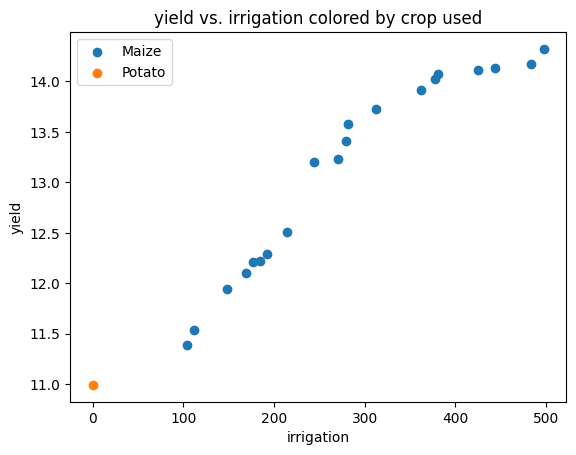

In [86]:
for action_crop in action_pareto["crops"].unique():
    subset = action_pareto[action_pareto["crops"] == action_crop]
    plt.scatter(-1 * subset["irr"], subset["yield"], label=action_crop)
plt.legend()
plt.xlabel("irrigation")
plt.ylabel("yield")
plt.title("yield vs. irrigation colored by crop used")
plt.show()

In [87]:
# Get all crops used in each generations
for gen in range(gens+1):
    gen_df = pd.read_csv(results_dir / f"{gen}.csv")
    gen_pareto = gen_df[gen_df["rank"] == 1]
    gen_crops = set()
    for cand_id in gen_pareto["cand_id"]:
        cand = get_candidate_from_id(results_dir, cand_id)
        actions = [get_candidate_actions(cand, w) for w in torch_weathers]
        for action in actions:
            gen_crops.add(action["crop"]["c_name"])
    print(gen, gen_crops)

0 {'Potato', 'Maize'}
1 {'Wheat', 'Potato', 'Maize'}
2 {'Potato', 'Maize'}
3 {'Cotton', 'Potato', 'Maize', 'Tomato'}
4 {'Potato', 'Maize', 'Sorghum'}
5 {'Potato', 'Soybean', 'Maize'}
6 {'Potato', 'Soybean', 'Maize'}
7 {'Potato', 'Maize', 'Quinoa'}
8 {'Potato', 'Maize'}
9 {'Potato', 'Maize'}
10 {'Potato', 'Maize'}
11 {'Potato', 'Maize'}
12 {'Potato', 'Maize'}
13 {'Potato', 'Maize'}
14 {'Potato', 'Maize'}
15 {'Potato', 'Maize'}
16 {'Potato', 'Maize'}
17 {'Potato', 'Maize'}
